Analysis based on https://stasiuk.medium.com/pose-estimation-metrics-844c07ba0a78

### Importing Libraries

In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import ast
import seaborn as sns

### Reading COCO keypoints

In [363]:
with open('COCO/keypoints.json', 'r') as f:
    keypoints_list = json.load(f)

### Adding HPE and COCO keypoints splitting

In [364]:
hpe_attrs_list = ['nose', 'chest', 'right_shoulder', 'right_elbow', 'right_wrist', 'left_shoulder', 'left_elbow', 
              'left_wrist', 'right_hip', 'right_knee', 'right_ankle', 'left_hip', 'left_knee', 'left_ankle',
              'right_eye', 'left_eye', 'right_ear', 'left_ear']

In [365]:
coco_attrs_list = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 
                   'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']

### HPE attributes with x, y and score values

In [366]:
main_list = []
for img in keypoints_list:
    img_id = int(img['Img_ID'])
    for index, person in enumerate(img['people']):
        person_obj = {}
        person_obj['Img_ID'] = img_id
        person_obj['ID'] = f'{img_id}{index+1}'
        for i, attr in enumerate(hpe_attrs_list):
            person_obj[f'{attr}_x'] = person[i]['x']
            person_obj[f'{attr}_y'] = person[i]['y']
            person_obj[f'{attr}_score'] = person[i]['score']
        main_list.append(person_obj)

### DataFrame reads

In [367]:
main_df = pd.DataFrame(main_list)

In [368]:
anns_df = pd.read_csv('../data/coco_diff/single_anns/person_anns.csv')
anns_df['scale'] = np.sqrt(anns_df['height']*anns_df['width'])
img_list = set(main_df['Img_ID'])

In [369]:
img_anns_df = anns_df[anns_df['Img'].isin(img_list)]
img_anns_df = img_anns_df[['Img', 'person_num', 'num_people', 'keypoints', 'img_size', 'scale', 'area_norm', 'offset', 'vis_face_ratio', 'vis_body_ratio', 'vis_extremities_ratio']]

### Adding x, y and values for each COCO keypoints

In [370]:
def keypoints_handling(row):
    keypoints_list = ast.literal_eval(row['keypoints'])
    for index, attr in enumerate(coco_attrs_list):
        row[f'{attr}_x_coco'] = keypoints_list[index*3]
        row[f'{attr}_y_coco'] = keypoints_list[index*3+1]
        row[f'{attr}_v_coco'] = keypoints_list[index*3+2]        
    return row

img_anns_df = img_anns_df.apply(keypoints_handling, axis=1)

### Converting values as strings

In [371]:
img_anns_df = img_anns_df.drop('keypoints', axis=1)
img_anns_df['person_num'] = img_anns_df['person_num'].astype(str)
img_anns_df['ID'] = img_anns_df['Img'].astype(str)+img_anns_df['person_num']

### Remove chest keypoint, not present in COCO

In [372]:
main_df = main_df.drop(['chest_x', 'chest_y', 'chest_score'], axis=1)

### Joins the two datasets

In [373]:
merged_df = pd.merge(main_df, img_anns_df, left_on='Img_ID', right_on='Img', how='inner')

### Sets euclidean distance between two points

In [374]:
oks_dict = {
    'nose': 0.026, 
    'left_eye': 0.025, 
    'right_eye': 0.025,  
    'left_ear': 0.035, 
    'right_ear': 0.035, 
    'left_shoulder': 0.079, 
    'right_shoulder': 0.079,  
    'left_elbow': 0.072, 
    'right_elbow': 0.072, 
    'left_wrist': 0.062, 
    'right_wrist': 0.062, 
    'left_hip': 0.107, 
    'right_hip': 0.107, 
    'left_knee': 0.087, 
    'right_knee': 0.087, 
    'left_ankle': 0.089, 
    'right_ankle': 0.089
}

In [375]:
for attr in coco_attrs_list:
    merged_df[f'{attr}_dist'] = np.sqrt((merged_df[f'{attr}_x']-merged_df[f'{attr}_x_coco'])**2+(merged_df[f'{attr}_y']-merged_df[f'{attr}_y_coco'])**2)
    merged_df[f'{attr}_oks'] = np.exp(-((merged_df[f'{attr}_dist']**2)/(2*merged_df['scale']**2*oks_dict[attr]**2)))

### Calculates oks score of keypoints detected from COCO if visibility > 0

In [376]:
dist_columns = [col for col in merged_df.columns if 'dist' in col]
vis_columns = [col for col in merged_df.columns if 'vis' in col]

In [377]:
def calculate_row_average(row):
    valid_distances = [row[f"{attr}_oks"] for attr in coco_attrs_list if row[f"{attr}_v_coco"] > 0]
    return (sum(valid_distances) / len(valid_distances)) if valid_distances else None

merged_df['avg_oks'] = merged_df.apply(calculate_row_average, axis=1)
merged_df = merged_df.dropna(subset=['avg_oks'])

In [378]:
score_cols_list = [col for col in merged_df.columns if col.endswith('_score')]
def compute_mean_score(row):
    scores = [row[col] for col in score_cols_list if row[f"{col.replace('score', 'v_coco')}"] > 0]
    return sum(scores) / len(scores) if scores else None 

merged_df['avg_score'] = merged_df.apply(compute_mean_score, axis=1)

### Gets, for each ID, the values with lowest average distance (so the set of keypoints detected)

In [379]:
df_lowest_avg = merged_df.loc[merged_df.groupby('ID_x')['avg_oks'].idxmax()]

Putting 0.75 as detection threshold

In [380]:
df_lowest_avg['detected'] = (df_lowest_avg['avg_oks']>=0.75).astype(int)

### Get format images

In [381]:
format_predictions_df = pd.read_csv('../data/yolo_prediction/All.csv')[['Img_ID', 'Format']]
format_predictions_df = format_predictions_df.groupby('Img_ID').first()

In [382]:
df_lowest_avg = pd.merge(format_predictions_df, df_lowest_avg, on='Img_ID', how='inner')

### Load images annotations dataset

In [383]:
all_anns_df = pd.read_csv('../data/coco_diff/All.csv')

In [384]:
keypoints_df = df_lowest_avg.copy()

Gets aggregated scores - oks, score, Format and precision

In [385]:
img_keypoints_df = keypoints_df[['Img_ID', 'avg_oks', 'avg_score', 'Format', 'detected']].groupby('Img_ID').agg({
        'avg_oks': 'mean',
        'avg_score': 'mean',
        'Format': 'first',
        'detected': 'mean'
    })
img_keypoints_df = img_keypoints_df.rename(columns={'detected': 'precision'})

In [386]:
def apply_total_dif_labeling(df, col):
    conditions = [
        (df[f'{col}'] < 0.4),
        (df[f'{col}'] > 0.85),
        (df[f'{col}'] > 0.6) & (df[f'{col}'] <= 0.85),
        (df[f'{col}'] >= 0.4) & (df[f'{col}'] <= 0.6)
    ]
    choices = ['easy', 'very hard', 'hard', 'medium']
    df['label'] = np.select(conditions, choices, default='unknown')
    return df

In [387]:
all_anns_df = apply_total_dif_labeling(all_anns_df, 'total_dif')

In [388]:
img_keypoints_merged_df = pd.merge(all_anns_df, img_keypoints_df, left_on="Img", right_on="Img_ID", how='inner')

## Analysis

### Scatter plots of distance-score

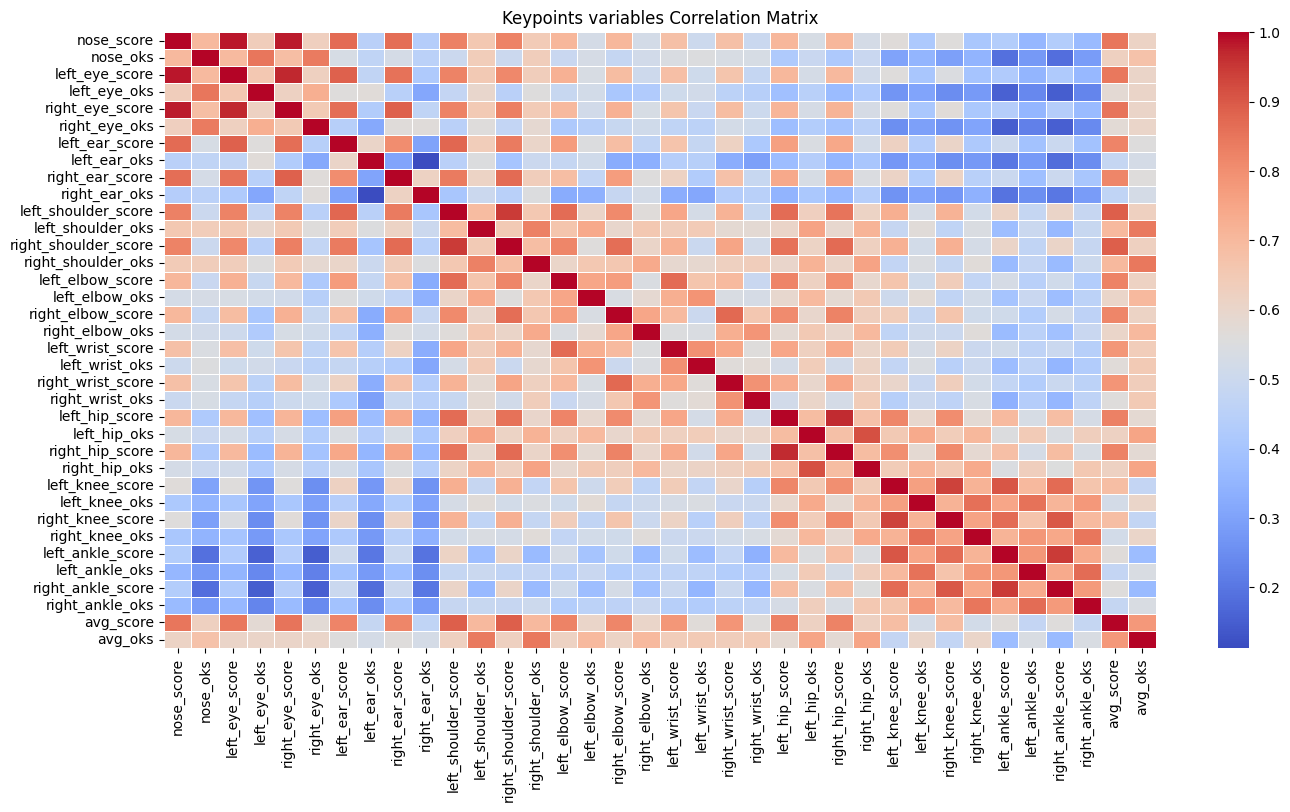

In [389]:
kp_corr_matrix = keypoints_df[[col for attr in coco_attrs_list for col in (f"{attr}_score", f"{attr}_oks")] + ['avg_score', 'avg_oks']].corr()
plt.figure(figsize=(16,8))
sns.heatmap(kp_corr_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot=False)
plt.title('Keypoints variables Correlation Matrix')
plt.show()

Of course upper body keypoints score and oks are highly correlated, as well as lower body keypoints score and keypoints

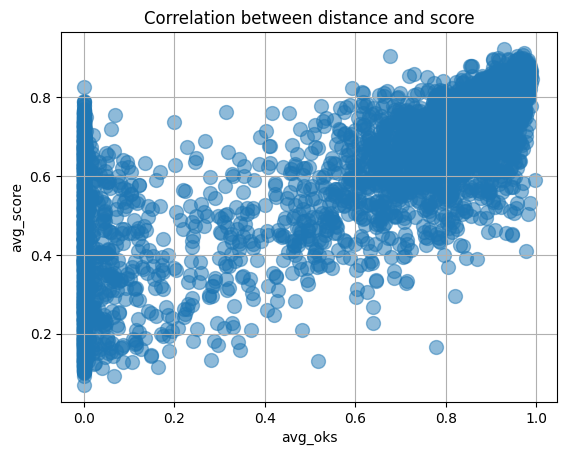

In [390]:
keypoints_df.plot(
    kind="scatter", 
    x='avg_oks', y='avg_score',
    s=100,       
    alpha=0.5    
)

plt.title("Correlation between distance and score")
plt.xlabel("avg_oks")
plt.ylabel("avg_score")        
plt.grid(True)            

plt.show()


In [391]:
float(keypoints_df['avg_oks'].corr(keypoints_df['avg_score']))

0.7807089116458092

Keypoints score and oks are highly correlated too, with 0.78 correlation factor

### Boxplots by label

In [392]:
def plot_grouped_boxplot(df, feature, name=None, subplot=None):
    if not subplot:
        plt.figure(figsize=(8, 6))
        
    custom_palette = {
        'easy': 'yellow',
        'medium': 'orange',
        'hard': 'red',
        'very hard': 'purple'
    }

    label_order = ['easy', 'medium', 'hard', 'very hard']


    sns.boxplot(data=df, x='label', y=feature, hue='label', palette=custom_palette, dodge=False, legend=False, order=label_order)
    if name:
        plt.title(f"Boxplot of {feature} by Label - {name}")
    else:
        plt.title(f"Boxplot of {feature} by Label")
    plt.xlabel("Label")
    plt.ylabel(f"{feature}")

    if not subplot:
        plt.show()

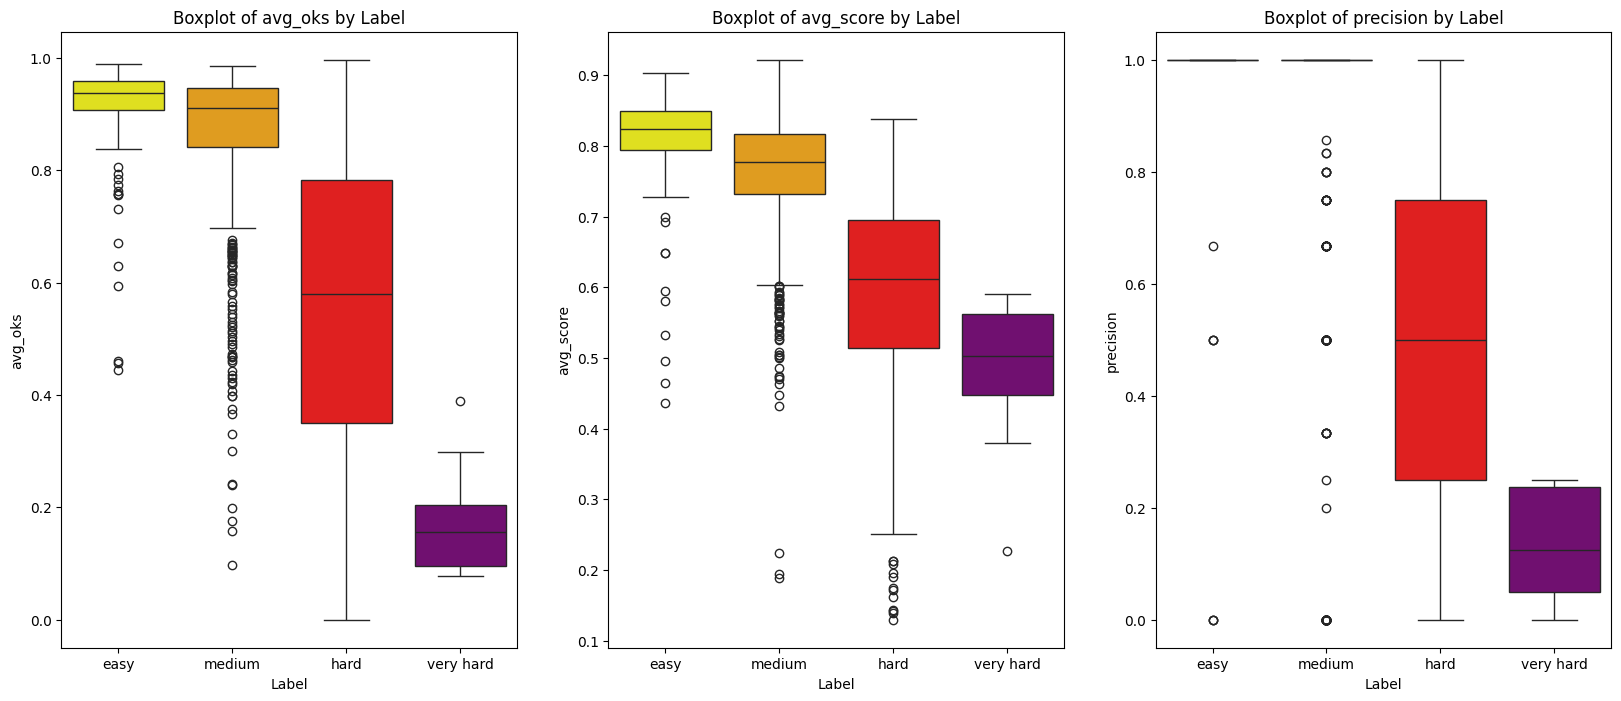

In [393]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plot_grouped_boxplot(img_keypoints_merged_df, 'avg_oks', subplot=True)
plt.subplot(1, 3, 2)
plot_grouped_boxplot(img_keypoints_merged_df, 'avg_score', subplot=True)
plt.subplot(1, 3, 3)
plot_grouped_boxplot(img_keypoints_merged_df, 'precision', subplot=True)
plt.show()

There is a huge difference between medium and hard images for oks and a minimal difference in score. Precision seems to be perfect for easy and medium, while it becomes way worse for hard and very hard

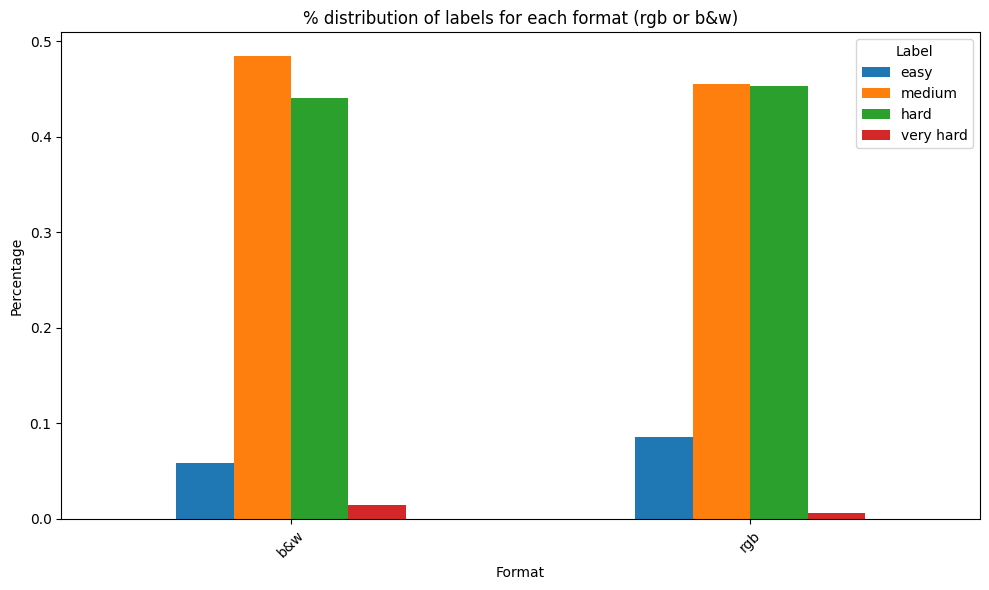

% distribution of labels for each format

label      easy    medium      hard  very hard
b&w    0.058824  0.485294  0.441176   0.014706
rgb    0.085395  0.455830  0.452886   0.005889

--------------------

Count of labels for each format

label   easy  hard  medium  very hard
Format                               
b&w        4    30      33          1
rgb      145   769     774         10


In [394]:
order_label = ['easy', 'medium', 'hard', 'very hard'] 
grouped_n = img_keypoints_merged_df.groupby('Format')['label'].value_counts(normalize=True).unstack(fill_value=0)
grouped = img_keypoints_merged_df.groupby('Format')['label'].value_counts().unstack(fill_value=0)

grouped_n.index = pd.Categorical(grouped_n.index, ordered=True)
grouped_n = grouped_n.sort_index()

grouped_n = grouped_n[order_label]

grouped_n.plot(kind='bar', stacked=False, figsize=(10, 6))

plt.title('% distribution of labels for each format (rgb or b&w)')
plt.xlabel('Format')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Label', loc='upper right')

plt.tight_layout()
plt.show()

print('% distribution of labels for each format')
print()
print(grouped_n)
print()
print('-'*20)
print()
print('Count of labels for each format')
print()
print(grouped)

### Boxplot of dist and score for each format

In [395]:
rgb_df = img_keypoints_merged_df[img_keypoints_merged_df['Format']=='rgb']
bew_df = img_keypoints_merged_df[img_keypoints_merged_df['Format']=='b&w']

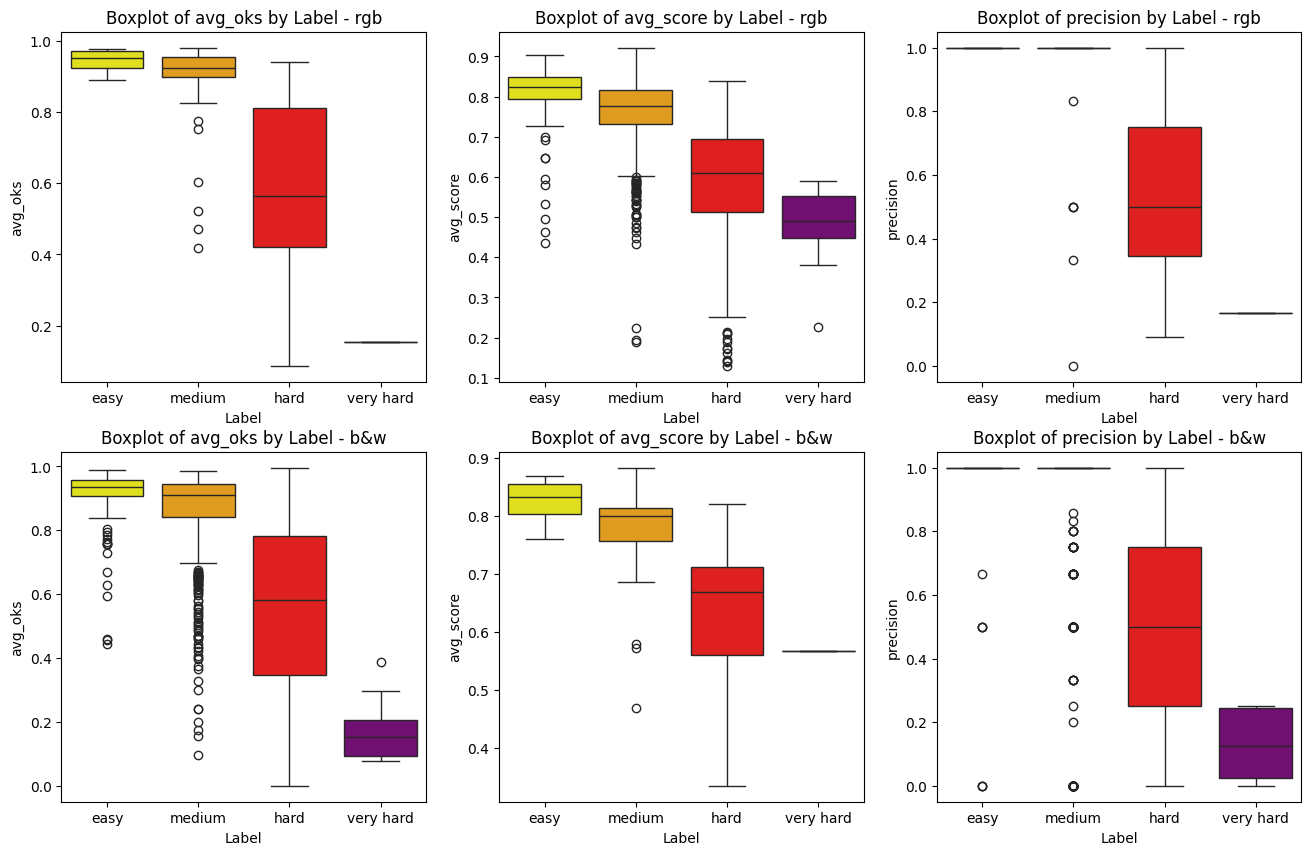

In [396]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 3, 1)
plot_grouped_boxplot(bew_df, 'avg_oks', name='rgb', subplot=True)
plt.subplot(2, 3, 2)
plot_grouped_boxplot(rgb_df, 'avg_score', name='rgb', subplot=True)
plt.subplot(2, 3, 3)
plot_grouped_boxplot(bew_df, 'precision', name='rgb', subplot=True)
plt.subplot(2, 3, 4)
plot_grouped_boxplot(rgb_df, 'avg_oks', name='b&w', subplot=True)
plt.subplot(2, 3, 5)
plot_grouped_boxplot(bew_df, 'avg_score', name='b&w', subplot=True)
plt.subplot(2, 3, 6)
plot_grouped_boxplot(rgb_df, 'precision', name='b&w', subplot=True)
plt.show()

Here b&w and rgb look behaving very similarly, with equal boxplots. So it seems that there is no difference in the two

In [397]:
diff = ['people_size_diff', 'num_people_diff', 'visibility_diff', 'offset_diff', 'total_dif']

<Axes: >

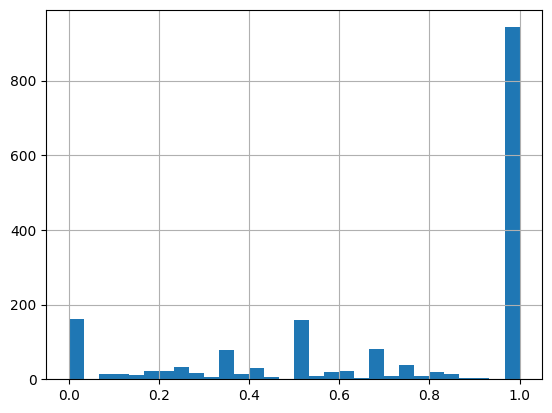

In [398]:
img_keypoints_merged_df['precision'].hist(bins=30)

In [399]:
precision_1 = img_keypoints_merged_df[img_keypoints_merged_df['precision'] == 1]
precision_0 = img_keypoints_merged_df[img_keypoints_merged_df['precision'] < 1]

As the majority of the predictions have 1 as precision, we choose that as threshold in order to investigate "bad detections"

In [400]:
def comparison_diff(ax, df1, df2, n1, n2, diff, color):
    df1[f'{diff}'].plot(kind='kde', color='blue', label=n1, ax=ax) 
    df2[f'{diff}'].plot(kind='kde', color=f'{color}', label=n2, ax=ax) 

    ax.set_xlabel(diff)
    ax.set_ylabel('Density') 
    ax.set_title(f'Density of {diff}')
    ax.legend()
    if diff != 'num_people_diff':
        ax.set_xlim(0, 1.1)

In [401]:
def add_category_distribution(ax, df1, df2, n1, n2, color):

    original_counts = df1['label'].value_counts(normalize=True)  
    precision_counts = df2['label'].value_counts(normalize=True)

    categories = ['easy', 'medium', 'hard']
    comparison_df = pd.DataFrame({
        n1: [original_counts.get(cat, 0) for cat in categories],
        n2: [precision_counts.get(cat, 0) for cat in categories]
    }, index=categories)

    comparison_df.plot(kind='bar', ax=ax, color=['blue', f'{color}'], width=0.4, position=1)

    ax.set_title('Category Distribution: Easy, Medium, Hard')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left')

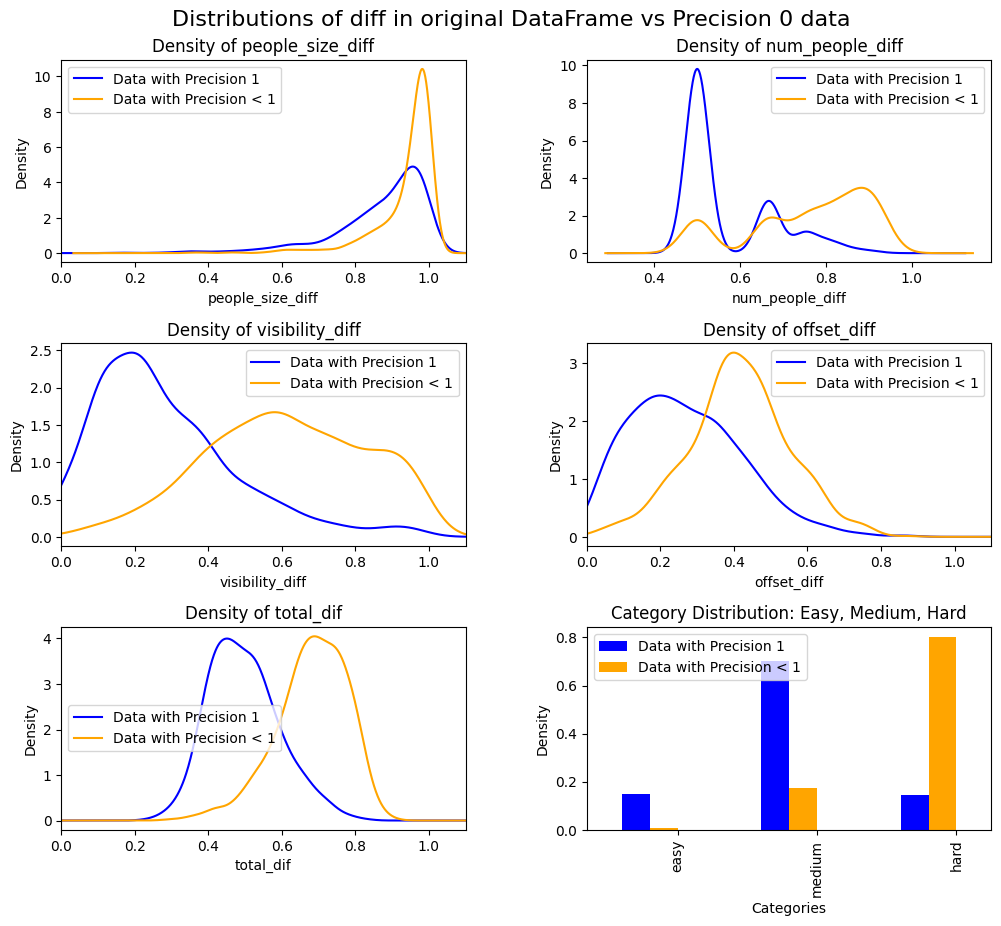

In [402]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10)) 
fig.suptitle('Distributions of diff in original DataFrame vs Precision 0 data', fontsize=16, y=0.93)

for index, dif in enumerate(diff):
    ax = axes[index // 2, index % 2] 
    comparison_diff(ax, precision_1, precision_0, 'Data with Precision 1', 'Data with Precision < 1', dif, 'orange')

plt.subplots_adjust(hspace=0.3)  
ax = axes[-1, -1]  

add_category_distribution(ax, precision_1, precision_0, 'Data with Precision 1', 'Data with Precision < 1', 'orange')


plt.subplots_adjust(hspace=0.4, wspace=0.3)  
plt.show()

As with YOLO, num_people_diff looks crucial for a perfect detection as well as visibility_diff. People_size_diff looks impacting too, but not that much. Offset_diff, as earlier, doesn't impact much the model.